## P4 Advanced Lane Finding 
### By: Chris Gundling
### Simplified Code for Video Processing 

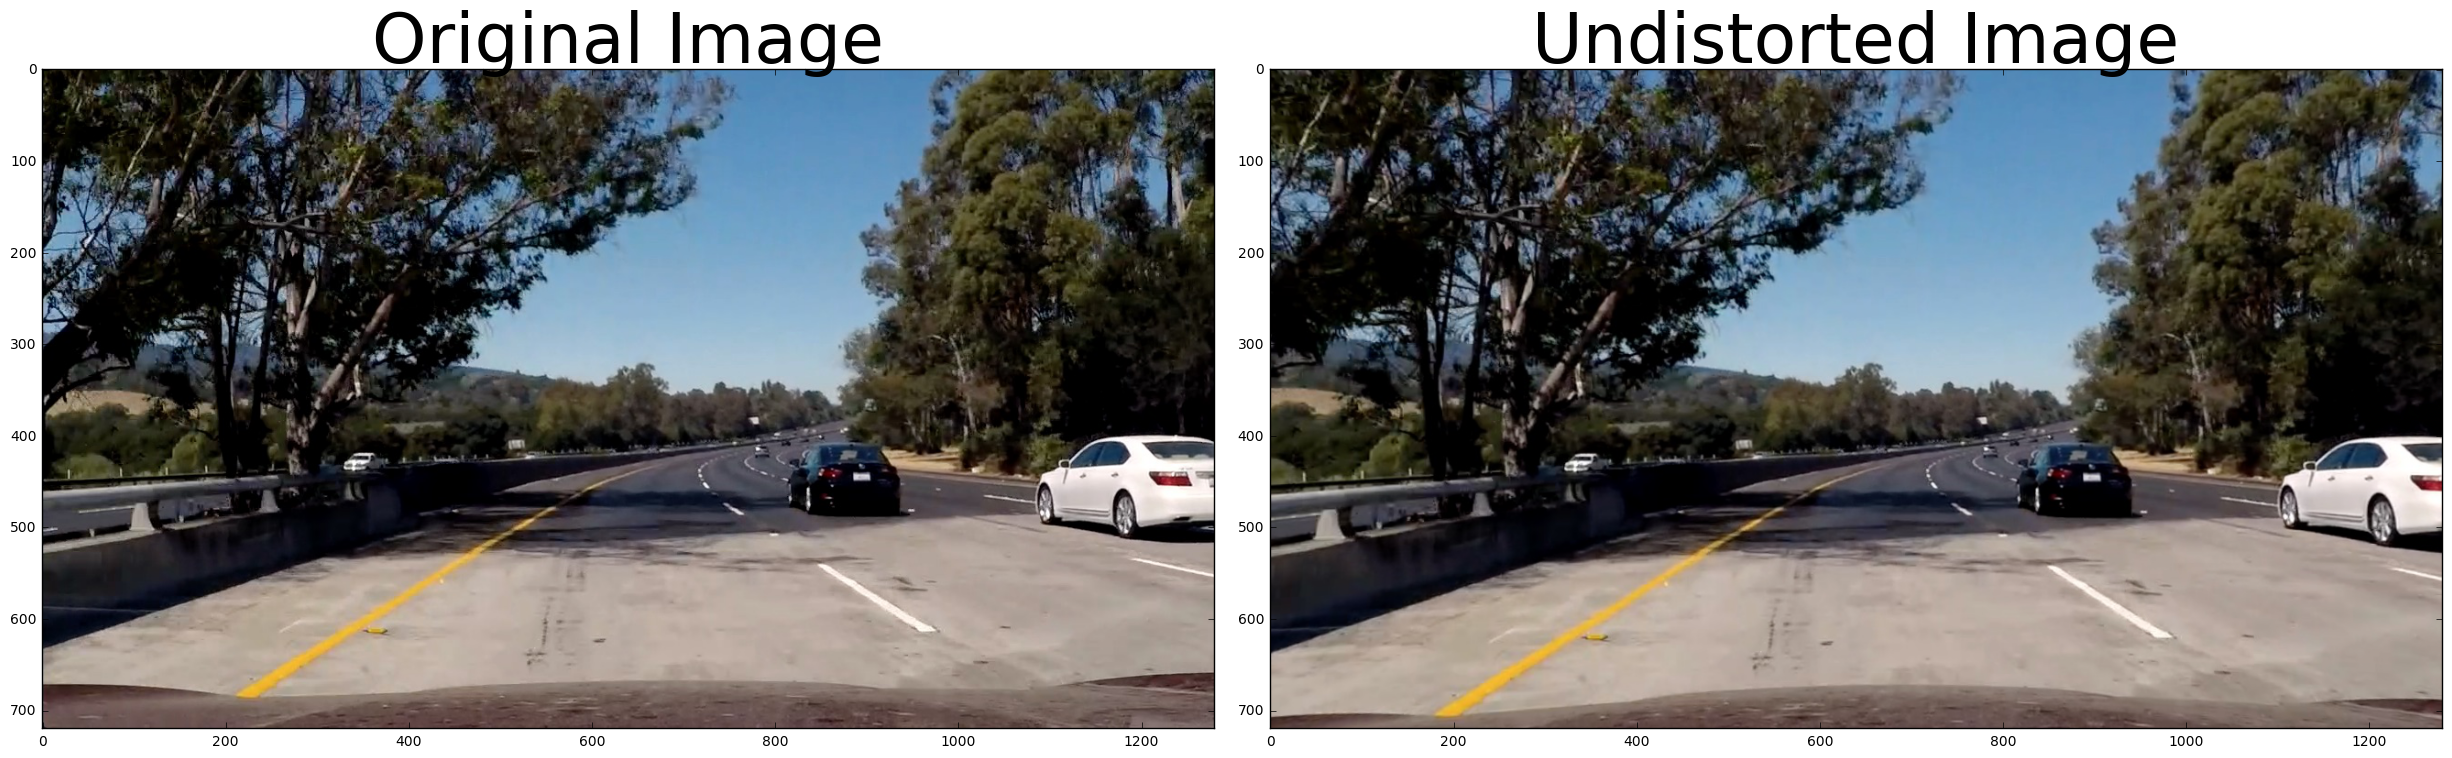

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

#####################################################################################
# Perform Calibration Steps
#####################################################################################
images = glob.glob('./camera_cal/calibration*.jpg')

# prepare object points
nx = 9
ny = 6

# Arrays for object and image points
objpoints = [] # 3D point in real world space
imgpoints = [] # 2D point in image plane
img_corners = []

# Prepare arrays 
objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # xy coords

# Undistort function
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

# Warping function
def corners_unwarp(img, nx, ny, mtx, dist, corners):   
    offset = 100 # offset for dst points
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
   
    # Source and destination points
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                            [img_size[0]-offset, img_size[1]-offset], 
                            [offset, img_size[1]-offset]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

j = 0
for fname in images:
    
    img = cv2.imread(fname)
        
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        j = j + 1
        imgpoints.append(corners)
        objpoints.append(objp)
        img_corners.append(cv2.drawChessboardCorners(img, (nx, ny), corners, ret))  

# Calibrate image
undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

# Warp image
img_warped, M = corners_unwarp(img, nx, ny, mtx, dist, corners)

img = cv2.imread('./test_images/test5.jpg')
# Calibrate image
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

# Now plot an example of the undistorted/warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)  

In [2]:
#####################################################################################
# Define functions for image processing
#####################################################################################

# -----------------------------------------------------------------------------------
# Birds-eye perspective transform
def birds_eye(img):      
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Four Source Points
    src = np.float32(
        [[580, 460],
         [200, 720],
         [706, 460], 
         [1140, 720]])
    
    # Four Destination Points
    dst = np.float32(
        [[200, 100],
         [200, 720],
         [1040, 100], 
         [1040, 720]]) 
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

# -----------------------------------------------------------------------------------
# Sobel threshold x or y
def abs_sobel_thresh(img, orient='x', thresh_min=5, thresh_max=100, HLS=False):
    if HLS == False:
        # Convert to grayscale
        thresh_g = (180, 255)#(180, 255)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray2 = np.zeros_like(gray)
        gray2[(gray > thresh_g[0]) & (gray <= thresh_g[1])] = 1
        gray = gray2
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        to_hls = cv2.cvtColor(gray, cv2.COLOR_RGB2HLS)
        gray = to_hls[:,:,2]
        thresh_s = (160, 255)#(150, 255)
        gray2 = np.zeros_like(gray)
        gray2[(gray > thresh_s[0]) & (gray <= thresh_s[1])] = 1
        gray = gray2

    # Apply x or y gradient with the OpenCV Sobel() function and take absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output


# -----------------------------------------------------------------------------------
# Gradient Magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255),HLS=False):
    if HLS == False:
        # Grayscale
        thresh_g = (180, 255)#(180, 255)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray2 = np.zeros_like(gray)
        gray2[(gray > thresh_g[0]) & (gray <= thresh_g[1])] = 1
        gray = gray2
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        to_hls = cv2.cvtColor(gray, cv2.COLOR_RGB2HLS)
        gray = to_hls[:,:,2]
        thresh_s = (160, 255)#(150, 255)
        gray2 = np.zeros_like(gray)
        gray2[(gray > thresh_s[0]) & (gray <= thresh_s[1])] = 1
        gray = gray2
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output


# -----------------------------------------------------------------------------------
# Directional threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2),HLS=False):
    if HLS == False:
        # Grayscale
        thresh_g = (180, 255)#(180, 255)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray2 = np.zeros_like(gray)
        gray2[(gray > thresh_g[0]) & (gray <= thresh_g[1])] = 1
        gray = gray2
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        to_hls = cv2.cvtColor(gray, cv2.COLOR_RGB2HLS)
        gray = to_hls[:,:,2]
        thresh_s = (160, 255)#(150, 255)
        gray2 = np.zeros_like(gray)
        gray2[(gray > thresh_s[0]) & (gray <= thresh_s[1])] = 1
        gray = gray2

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output 


# -----------------------------------------------------------------------------------
# Take histogram of final binary image output
def hist_binary(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    return histogram


# -----------------------------------------------------------------------------------
# Perform sliding windows operation to determine lane lines
def sliding_windows(histogram, binary_warped, count, method):

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # ---------------------------------------------------------------------------------
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[150:midpoint]) + 150
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 120

    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    # ---------------------------------------------------------------------------------
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Method used for fits
    left_method = 2
    right_method = 2
    left_fit = np.zeros(3)
    right_fit = np.zeros(3)
    
    '''
    The goal of these next steps is to perform several checks on the lane pixels 
    to determine if a proper fit can be achieved:
    if yes, then method = 2 
    if no, then method = 1 
    and the previous timeframe's fit is appended to the stored fits
    '''
    
    # Lane prediction confidence (hardcode values determined from straight line images)
    # ---------------------------------------------------------------------------------
    good_pixel_count_left = 11000.
    good_pixel_count_right = 3000.
    left_conf = 1. - abs(good_pixel_count_left - len(left_lane_inds))/ 15000.
    right_conf = 1. - abs(good_pixel_count_right - len(right_lane_inds))/ 8000.
    
    if len(left_lane_inds) < good_pixel_count_left:
        left_conf = 1.
    
    if left_conf < 0:
        left_conf = 0
        left_method = 1 
           
    if len(right_lane_inds) < good_pixel_count_right:
        right_conf = 1.
        
    if right_conf < 0:
        right_conf = 0
        right_method = 1    
        
    # Check lane width
    # ---------------------------------------------------------------------------------
    if np.mean(rightx) - np.mean(leftx) > 1000 or np.mean(rightx) - np.mean(leftx) < 720:
        left_method = 1
        right_method = 1
    
    # Check to make sure that pixels exist for each lane
    # Create curve fits on current frame and append or use previous frame
    # ---------------------------------------------------------------------------------
    if rightx.size == 0 or righty.size == 0:
        store_right_fit[count,:] = store_right_fit[count-1,:]
        right_method = 1 
             
    if leftx.size == 0 or lefty.size == 0:
        store_left_fit[count,:] = store_left_fit[count-1,:]
        left_method = 1
    
    if right_method == 1:
        store_right_fit[count,:] = store_right_fit[count-1,:]
        
    if left_method == 1:
        store_left_fit[count,:] = store_left_fit[count-1,:]
        
    if left_method == 2 or count <= 20:
        # Fit a second order polynomial to left lane
        left_fit = np.polyfit(lefty, leftx, 2)
        store_left_fit[count,:] = left_fit
        
    if right_method == 2 or count <= 20:
        # Fit a second order polynomial to right lane
        right_fit = np.polyfit(righty, rightx, 2)
        store_right_fit[count,:] = right_fit  
        
    diff_left = np.zeros((2))
    diff_right = np.zeros((2))
    
    # Check Max and min values of Fit Coefficient
    # Determined max/min values from plots of 2nd order curves
    # ---------------------------------------------------------------------------------
    if store_left_fit[count,0] > 0.0025:
        store_left_fit[count,0] = 0.0025
    
    if store_left_fit[count,0] < -0.0025:
        store_left_fit[count,0] = -0.0025
        
    if store_left_fit[count,1] > 3.0:
        store_left_fit[count,1] = 3.0
    
    if store_left_fit[count,1] < -3.0:
        store_left_fit[count,1] = -3.0
        
    if store_right_fit[count,0] > 0.0025:
        store_right_fit[count,0] = 0.0025
    
    if store_right_fit[count,0] < -0.0025:
        store_right_fit[count,0] = -0.0025
        
    if store_right_fit[count,1] > 3.0:
        store_right_fit[count,1] = 3.0
    
    if store_right_fit[count,1] < -3.0:
        store_right_fit[count,1] = -3.0
        
    # Check the current step fit values and remove outliers
    # ---------------------------------------------------------------------------------
    #if count > 15:
    #    diff_left[0] = abs(store_left_fit[count,0] - store_left_fit[count-1,0]) / store_left_fit[count,0])
    #    diff_left[1] = abs((store_left_fit[count,1] - store_left_fit[count-1,1]) / store_left_fit[count,1])
        
    #    diff_right[0] = abs((store_right_fit[count,0] - store_right_fit[count-1,0]) / store_right_fit[count,0])
    #    diff_right[1] = abs((store_right_fit[count,1] - store_right_fit[count-1,1]) / store_right_fit[count,1])
    
    #    if np.max(diff_left) > 3 or np.max(diff_right) > 3:
    #        store_left_fit[count,:] = store_left_fit[count-1,:]
    #        store_right_fit[count,:] = store_right_fit[count-1,:]
    
    # Average the final accepted fits to produce final fit
    # ---------------------------------------------------------------------------------
    if count > 20:
        left_fit[0] = np.mean(store_left_fit[count-20:count,0])
        left_fit[1] = np.mean(store_left_fit[count-20:count,1])
        left_fit[2] = np.mean(store_left_fit[count-20:count,2])
        right_fit[0] = np.mean(store_right_fit[count-20:count,0])
        right_fit[1] = np.mean(store_right_fit[count-20:count,1])
        right_fit[2] = np.mean(store_right_fit[count-20:count,2])
    
    # Visualize the output image
    # Generate x and y values for plotting
    # ---------------------------------------------------------------------------------
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, rightx, lefty, righty, detected, left_conf, right_conf, method


# -----------------------------------------------------------------------------------
# Assume you now have a new warped binary image 
def find_lines(left_fit, right_fit, binary_warped, count, method):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Method used for fits
    left_method = 2
    right_method = 2
    left_fit = np.zeros(3)
    right_fit = np.zeros(3)
    
    '''
    The goal of these next steps is to perform several checks on the lane pixels 
    to determine if a proper fit can be achieved:
    if yes, then method = 2 
    if no, then method = 1 
    and the previous timeframe's fit is appended to the stored fits
    '''
    
    # Lane prediction confidence (hardcode values determined from straight line images)
    # ---------------------------------------------------------------------------------
    good_pixel_count_left = 11000.
    good_pixel_count_right = 3000.
    left_conf = 1. - abs(good_pixel_count_left - len(left_lane_inds))/ 15000.
    right_conf = 1. - abs(good_pixel_count_right - len(right_lane_inds))/ 8000.
    
    if len(left_lane_inds) < good_pixel_count_left:
        left_conf = 1.
    
    if left_conf < 0:
        left_conf = 0
        left_method = 1 
           
    if len(right_lane_inds) < good_pixel_count_right:
        right_conf = 1.
        
    if right_conf < 0:
        right_conf = 0
        right_method = 1    
        
    # Check lane width
    # ---------------------------------------------------------------------------------
    if np.mean(rightx) - np.mean(leftx) > 1000 or np.mean(rightx) - np.mean(leftx) < 720:
        left_method = 1
        right_method = 1
    
    # Check to make sure that pixels exist for each lane
    # Create curve fits on current frame and append or use previous frame
    # ---------------------------------------------------------------------------------
    if rightx.size == 0 or righty.size == 0:
        store_right_fit[count,:] = store_right_fit[count-1,:]
        right_method = 1 
             
    if leftx.size == 0 or lefty.size == 0:
        store_left_fit[count,:] = store_left_fit[count-1,:]
        left_method = 1
    
    if right_method == 1:
        store_right_fit[count,:] = store_right_fit[count-1,:]
        
    if left_method == 1:
        store_left_fit[count,:] = store_left_fit[count-1,:]
        
    if left_method == 2 or count <= 20:
        # Fit a second order polynomial to left lane
        left_fit = np.polyfit(lefty, leftx, 2)
        store_left_fit[count,:] = left_fit
        
    if right_method == 2 or count <= 20:
        # Fit a second order polynomial to right lane
        right_fit = np.polyfit(righty, rightx, 2)
        store_right_fit[count,:] = right_fit  
        
    diff_left = np.zeros((2))
    diff_right = np.zeros((2))
    
    # Check Max and min values of Fit Coefficient
    # Determined max/min values from plots of 2nd order curves
    # ---------------------------------------------------------------------------------
    if store_left_fit[count,0] > 0.0025:
        store_left_fit[count,0] = 0.0025
    
    if store_left_fit[count,0] < -0.0025:
        store_left_fit[count,0] = -0.0025
        
    if store_left_fit[count,1] > 3.0:
        store_left_fit[count,1] = 3.0
    
    if store_left_fit[count,1] < -3.0:
        store_left_fit[count,1] = -3.0
        
    if store_right_fit[count,0] > 0.0025:
        store_right_fit[count,0] = 0.0025
    
    if store_right_fit[count,0] < -0.0025:
        store_right_fit[count,0] = -0.0025
        
    if store_right_fit[count,1] > 3.0:
        store_right_fit[count,1] = 3.0
    
    if store_right_fit[count,1] < -3.0:
        store_right_fit[count,1] = -3.0
        
    # Check the current step fit values and remove outliers
    # ---------------------------------------------------------------------------------
    #if count > 15:
    #    diff_left[0] = abs(store_left_fit[count,0] - store_left_fit[count-1,0]) / store_left_fit[count,0])
    #    diff_left[1] = abs((store_left_fit[count,1] - store_left_fit[count-1,1]) / store_left_fit[count,1])
        
    #    diff_right[0] = abs((store_right_fit[count,0] - store_right_fit[count-1,0]) / store_right_fit[count,0])
    #    diff_right[1] = abs((store_right_fit[count,1] - store_right_fit[count-1,1]) / store_right_fit[count,1])
    
    #    if np.max(diff_left) > 3 or np.max(diff_right) > 3:
    #        store_left_fit[count,:] = store_left_fit[count-1,:]
    #        store_right_fit[count,:] = store_right_fit[count-1,:]
    
    # Average the final accepted fits to produce final fit
    # ---------------------------------------------------------------------------------
    if count > 20:
        left_fit[0] = np.mean(store_left_fit[count-20:count,0])
        left_fit[1] = np.mean(store_left_fit[count-20:count,1])
        left_fit[2] = np.mean(store_left_fit[count-20:count,2])
        right_fit[0] = np.mean(store_right_fit[count-20:count,0])
        right_fit[1] = np.mean(store_right_fit[count-20:count,1])
        right_fit[2] = np.mean(store_right_fit[count-20:count,2])

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, rightx, lefty, righty, detected, left_conf, right_conf, method

# -----------------------------------------------------------------------------------
# Draw the lines on the image
def draw_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, undistorted):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp2 = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Redo the left right points with smaller margin
    margin = 10
    margin_c = 3
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    center_line_window1 = np.array([np.transpose(np.vstack([(left_fitx + right_fitx)/2-margin_c, ploty]))])
    center_line_window2 = np.array([np.flipud(np.transpose(np.vstack([(left_fitx + right_fitx)/2 + margin_c, ploty])))])
    center_line_pts = np.hstack((center_line_window1, center_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(color_warp2, np.int_([left_line_pts]), (255, 255, 255))
    cv2.fillPoly(color_warp2, np.int_([right_line_pts]), (255, 255, 255))
    cv2.fillPoly(color_warp2, np.int_([center_line_pts]), (255, 255, 0))
    color_warp = cv2.addWeighted(color_warp, 1.0, color_warp2, 1.0, 0)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img = undistorted
    img_size = (img.shape[1], img.shape[0])
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 1.0, 0.0)
    
    return result

# -----------------------------------------------------------------------------------
# Define y-value where we want radius of curvature
def rad_curve(result, left_fit, right_fit, ploty, lefty, righty, leftx, rightx, left_conf, right_conf):
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/840 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Distance from center
    car_y = result.shape[0]
    left_line_location = left_fit[0]*car_y**2 + left_fit[1]*car_y + left_fit[2] 
    right_line_location = right_fit[0]*car_y**2 + right_fit[1]*car_y + right_fit[2]
    car_center = xm_per_pix*(result.shape[1] / 2)
    lane_center = xm_per_pix*((left_line_location + right_line_location) / 2)
    dist_center = car_center - lane_center

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Add to image
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result,'Left Curvature: %.2f m'%(left_curverad),(60,60), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right Curvature: %.2f m'%(right_curverad),(60,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Distance from Center : %.2f m'%(dist_center),(60,140), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Left Confidence : %.2f '%(left_conf*100.),(60,180), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right Confidence : %.2f '%(right_conf*100.),(60,220), font, 1,(255,255,255),2,cv2.LINE_AA)

    return result         

In [13]:
def process_image(img):
    global count, method, detected, left_fit, right_fit, store_left_fit, store_right_fit

    # Calibrate image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Birds-eye View
    bird, Minv = birds_eye(undistorted)

    # Apply Sobel Thresholding x
    gradx_s = abs_sobel_thresh(bird, orient='x', thresh_min=5, thresh_max=100, HLS=True)
    
    # Apply Sobel Thresholding y
    grady_s = abs_sobel_thresh(bird, orient='y', thresh_min=5, thresh_max=100, HLS=True)
    
    # Apply Magnitude Thresholding on HLS
    mag_binary_s = mag_thresh(bird, sobel_kernel=9, mag_thresh=(50, 200), HLS=False)
    
    # Apply Magniture on Grayscale
    mag_binary = mag_thresh(bird, sobel_kernel=9, mag_thresh=(50, 200),HLS=False)
    
    # Apply Directional Thresholding
    dir_binary_s = dir_threshold(bird, sobel_kernel=15, thresh=(0.7, 1.3), HLS=True)
    
    # Create the Binary Warped Image Using Thresholds
    binary_warped = np.zeros_like(dir_binary_s)
    binary_warped[((gradx_s == 1) & (grady_s == 1)) | (mag_binary_s == 1) | (dir_binary_s == 1) | (mag_binary == 1)] = 1

    # Take the Histogram
    histogram = hist_binary(binary_warped[:,:])
    #result = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Perform Sliding Windows Operation or Use Previous Step
    if count == 0:   
        left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, rightx, lefty, righty, detected, left_conf, right_conf, method = sliding_windows(histogram, binary_warped, count, method)
    else:
        left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, rightx, lefty, righty, detected, left_conf, right_conf, method = find_lines(left_fit, right_fit, binary_warped, count, method)
    
    # Draw the line on the images
    result = draw_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, undistorted)
    
    # Find radius of curvature and lane center
    result = rad_curve(result, left_fit, right_fit, ploty, lefty, righty, leftx, rightx, left_conf, right_conf)
    
    count += 1
    
    return result

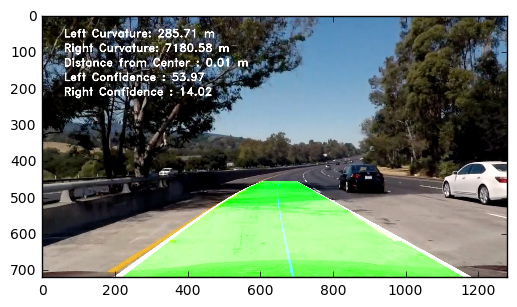

In [14]:
# Look at all the test images
detected = False
count = 0
store_left_fit = np.zeros((6,3))
store_right_fit = np.zeros((6,3))
method = 2
img = img = cv2.imread('./test_images/test5.jpg')
result = process_image(img)
#plt.imshow(result,cmap='gray')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

/Users/chrisgundling/enter/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:135: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


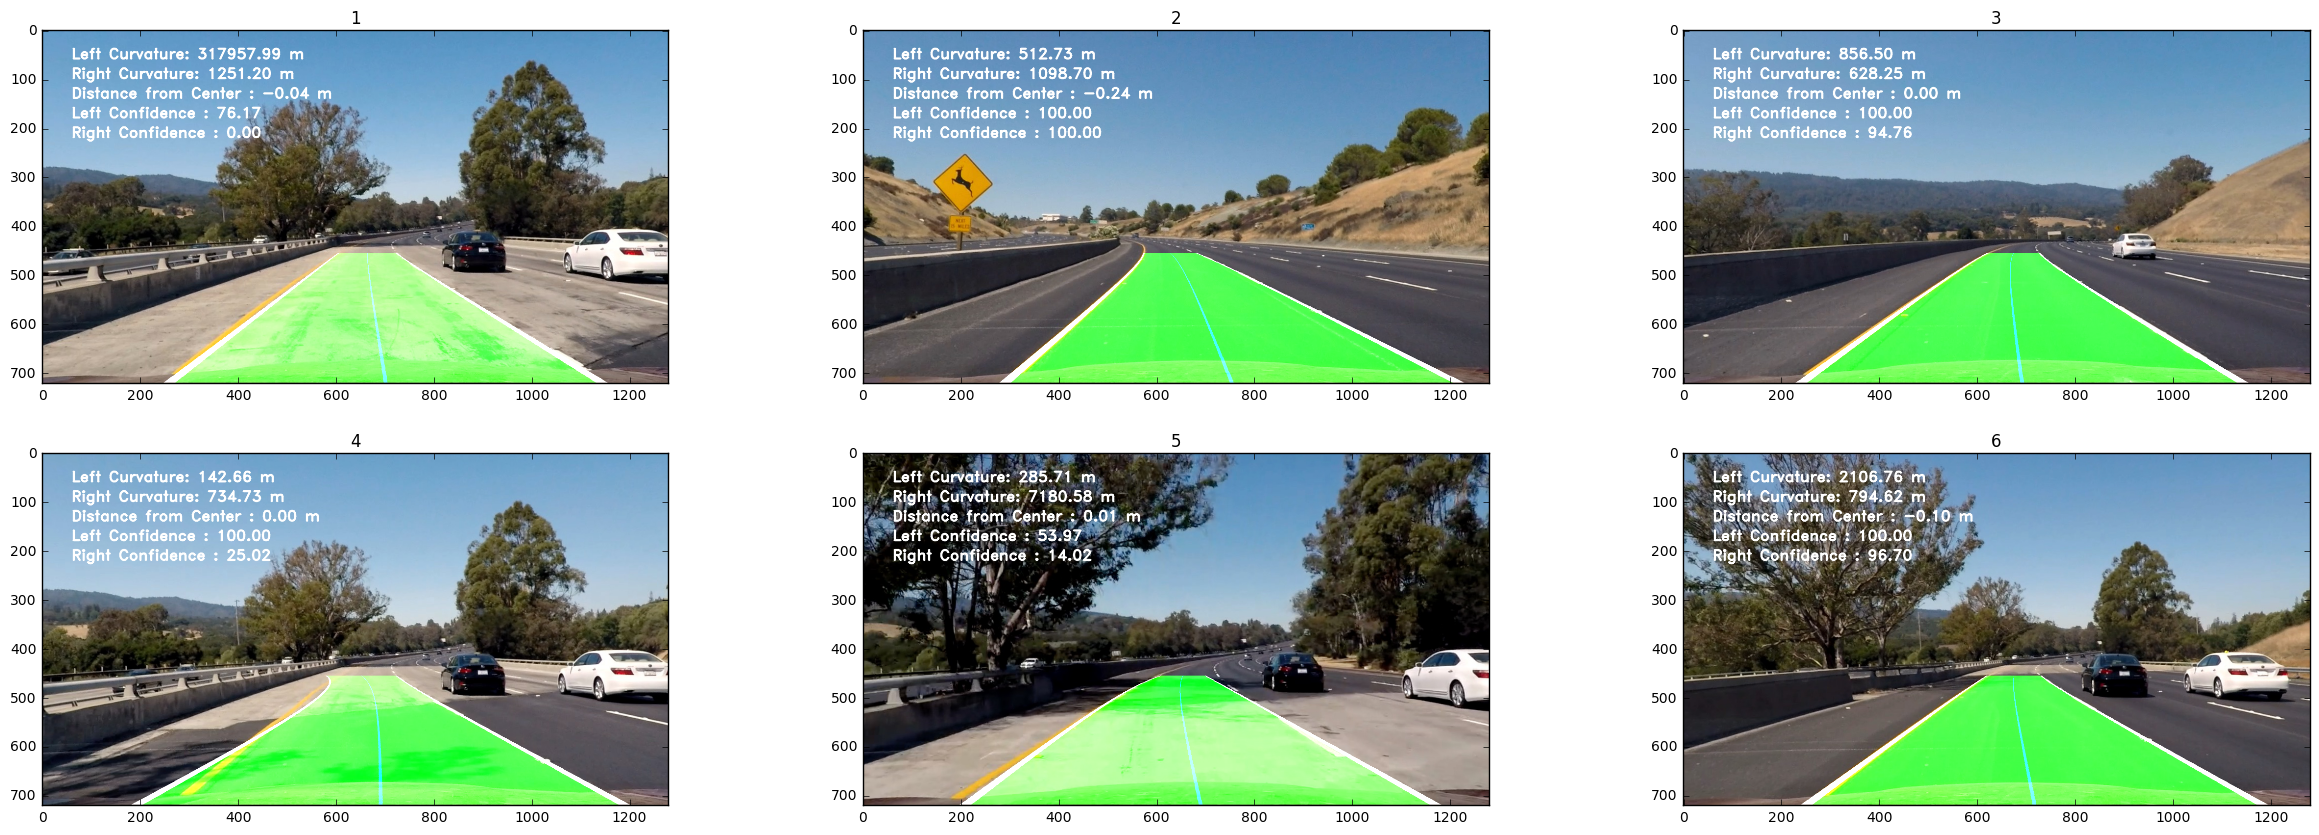

In [5]:
# Look at all the test images
images = glob.glob('./test_images/test*.jpg')
results = []
i = 0
detected = False
count = 0
store_left_fit = np.zeros((6,3))
store_right_fit = np.zeros((6,3))
method = 2
for fname in images:    
    img = cv2.imread(fname)
    result = process_image(img)
    plt.subplot(2,3,i+1)
    #plt.imshow(result,cmap='gray')
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    i = i + 1
    
for j in range(6):
    plt.subplot(2,3,j+1)
    plt.title(j+1)

fig = plt.gcf()
fig.set_size_inches(30, 10)
plt.show()         

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

def save_image(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imsave('./saved_images/challenge.jpg',img)
    return img
    
detected = False
count = 0
store_left_fit = np.zeros((1261,3))
store_right_fit = np.zeros((1261,3))
white_output = 'P4_finalvideo_binary.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(43,45)
white_clip = clip1.fl_image(process_image)
#white_clip = clip1.fl_image(save_image)
#plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video P4_finalvideo_binary.mp4
[MoviePy] Writing video P4_finalvideo_binary.mp4


100%|█████████▉| 1260/1261 [05:44<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_finalvideo_binary.mp4 

CPU times: user 5min 29s, sys: 1min 18s, total: 6min 48s
Wall time: 5min 45s
